#Long Short Trading Strategy Using Sentiment Analysis# 

Any trading strategy requires a set of calculations on multiple data inputs to analyze large amounts of assets at a time. Such calculations include:

- Selecting assets based on filtering rules
- Ranking assets based on a scoring function
- Calculating portfolio allocations

##Trading Universe Selection##

An important part of developing a strategy is defining the set of assets that we want to consider trading in our portfolio. This set of assets is usually refered to as the trading universe. A trading universe should be as large as possible, while also excluding assets that aren't appropriate for portfolio. For example, we might want to exclude stocks that are illiquid or difficult to trade.
Quantopian's *QTradableStocksUS* universe offers this characteristic. Therefore, *QTradableStocksUS* is used as the trading universe for the algorithm. The time period for which the data is taken into consideration is of 2 years starting from January 2107 to December 2019. 

##Calculating Sentiment Score## 

The goal in this research is to build an algorithm that selects and trades assets based on sentiment data. **PsychSignal's StockTwits Trader Mood Dataset** is one such data collection. PsychSignal's dataset assigns bull and bear scores to stocks each day based on the aggregate sentiment from messages posted on *Stocktwits*, a financial communications platform.

The sentiment score is calculated using 3 day moving average over the PyschSignal's *bull_minus_bear* column. The table in the output below shows sentiment scores calculated for the last 10 columns of the input dataset.

For simplicity, only the top 350 and bottom 350 stocks ranked by sentiment_score will be analyzed. 

In [4]:
# Pipeline imports
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.experimental import QTradableStocksUS

# Pipeline definition
def  make_pipeline():

    base_universe = QTradableStocksUS()

    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )

    # Create filter for top 350 and bottom 350
    # assets based on their sentiment scores
    top_bottom_scores = (
        sentiment_score.top(350) | sentiment_score.bottom(350)
    )

    return Pipeline(
        columns={
            'sentiment_score': sentiment_score,
        },
        # Set screen as the intersection between our filter
        # and trading universe
        screen=(
            base_universe
            & top_bottom_scores
        )
    )

In [5]:
# Import run_pipeline method
from quantopian.research import run_pipeline

# Specify a time range to evaluate
period_start = '2017-01-01'
period_end = '2019-11-01'

# Execute pipeline over evaluation period
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date=period_start,
    end_date=period_end
)
pipeline_output.tail(10)

sentiment_score
2019-11-01 00:00:00+00:00 Equity(50376 [CDEV])        -1.000000
                          Equity(50680 [HLNE])         2.600000
                          Equity(50718 [PUMP])        -1.116667
                          Equity(50869 [IR])          -1.683333
                          Equity(51338 [EYE])         -0.816667
                          Equity(51634 [AVYA])        -1.640000
                          Equity(51734 [VICI])         2.066667
                          Equity(52119 [TCDA])        -1.788667
                          Equity(52165 [DOMO])        -1.066667
                          Equity(52209 [ALLK])        -1.400000

###Strategy Definition###

In general, long-short equity strategies consist of modeling the relative value of assets with respect to each other, and placing bets on the sets of assets that we are confident will increase (long) and decrease (short) the most in value.
Long-short equity strategies profit as the spread in returns between the sets of high and low value assets increases. The quality of a long-short equity strategy relies entirely on the quality of its underling ranking model. In this algorithm a simple ranking schema is used.

*Strategy: Consider assets with a high 3 day average sentiment score as high value, and assets with a low 3 day average sentiment score as low value.*

Next, the algorithm uses Quantopian's open source factor analysis tool, Alphalens, to test the quality of the selection strategy. It first combines factor and pricing data using *get_clean_factor_and_forward_returns*. This function classifies our factor data into quantiles and computes forward returns for each security for multiple holding periods. We will separate our factor data into 2 quantiles (the top and bottom half), and use 1, 5 and 10 day holding periods.

The table below shows the output after factor analysis of the PsychSignal dataset.

In [4]:
# Import prices function
from quantopian.research import prices

# Get list of unique assets from the pipeline output
asset_list = pipeline_output.index.levels[1].unique()

# Query pricing data for all assets present during
# evaluation period
asset_prices = prices(
    asset_list,
    start=period_start,
    end=period_end
)

In [5]:
# Import Alphalens
import alphalens as al

# Get asset forward returns and quantile classification
# based on sentiment scores
factor_data = al.utils.get_clean_factor_and_forward_returns(
    factor=pipeline_output['sentiment_score'],
    prices=asset_prices,
    quantiles=2,
    periods=(1,5,10),
)

# Display last 5 rows
factor_data.tail(5)

Dropped 1.6% entries from factor data: 1.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        5D       10D  \
date                      asset                                                
2019-10-18 00:00:00+00:00 Equity(52033 [GSKY])  0.006623  0.013907  0.018543   
                          Equity(52045 [PRSP])  0.003116  0.002727  0.059603   
                          Equity(52155 [BV])    0.014092  0.016347  0.042277   
                          Equity(52209 [ALLK])  0.013392 -0.030098 -0.020986   
                          Equity(52427 [EB])    0.002849 -0.017094  0.063818   

                                                  factor  factor_quantile  
date                      asset                                            
2019-10-18 00:00:00+00:00 Equity(52033 [GSKY]) -0.906667                1  
                          Equity(52045 [PRSP]) -2.110000                1  
                          Equity(52155 [BV])    2.450000                2  
                          Equity(52209 [ALLK]) -1.311667                1  
                          Equity(52427 [EB])   -1.540000                1

###Results###

Having the data in this format allows the use of Alphalens's analysis and plotting tools. First, we plot the mean returns by quantile over the entire period. Because the goal is to build a long-short strategy, we want to see the lower quantile (1) have negative returns and the upper quantile(2) have positive returns.

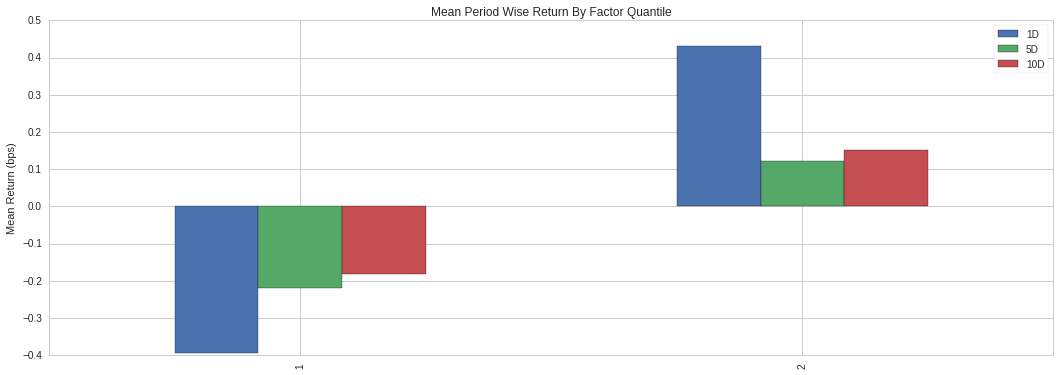

In [6]:
# Calculate mean return by factor quantile
mean_return_by_q, std_err_by_q = al.performance.mean_return_by_quantile(factor_data)

# Plot mean returns by quantile and holding period
# over evaluation time range
al.plotting.plot_quantile_returns_bar(
    mean_return_by_q.apply(
        al.utils.rate_of_return,
        axis=0,
        args=('1D',)
    )
);

Next, we plot the cumulative returns of a factor-weighted long-short portfolio with a 5 day holding period. 

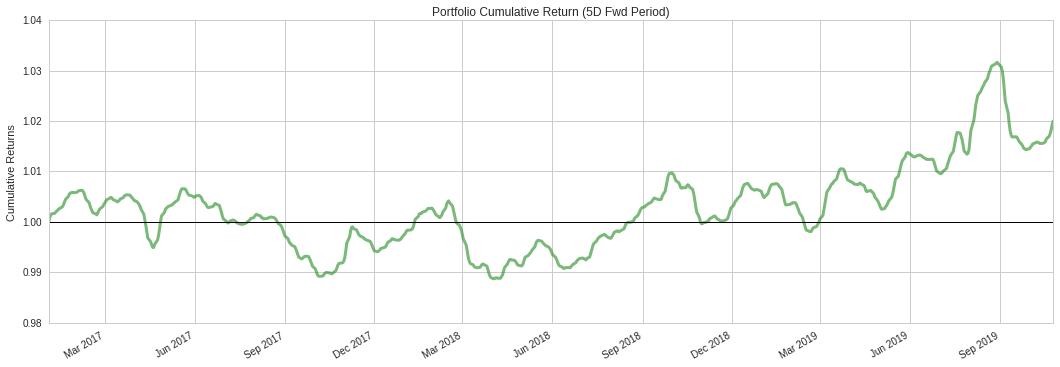

In [7]:
import pandas as pd
# Calculate factor-weighted long-short portfolio returns
ls_factor_returns = al.performance.factor_returns(factor_data)

# Plot cumulative returns for 5 day holding period
al.plotting.plot_cumulative_returns(ls_factor_returns['5D'], '5D', freq=pd.tseries.offsets.BDay());

Having created and tested a strategy, the next step is to Backtest the trading algorithm over Historical Data.

###Backtest Analysis###

The plot below shows our portfolio's rolling exposure to the market over time. One of the reasons to construct a long-short equity trading algorithm is to maintain a low correlation to the market, so we want this plot to be consistently around 0 over the entire backtesting period. It is evident from the plot below that the algorithm does maintain close to 0 over the entire backtest period.

100% Time:  0:00:44|##########################################################|


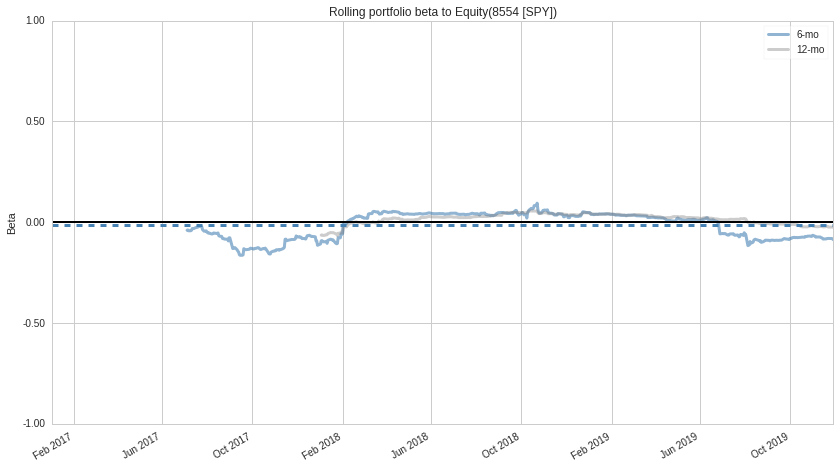

In [8]:
import pyfolio as pf
import matplotlib.pyplot as plt
import empyrical

# Get benchmark returns
benchmark_rets = pf.utils.get_symbol_rets('SPY')

bt = get_backtest('5e9f5340e8ba644829864126')
bt_returns = bt.daily_performance['returns']
bt_positions = bt.pyfolio_positions
bt_transactions = bt.pyfolio_transactions
pf.plot_rolling_beta(bt_returns, benchmark_rets);

The plot below uses Quantopian's Risk Model to illustrate how much of the returns can be attributed to the strategy, and how much of it comes from common risk factors.We can see below from the *Time series of cumulative returns* graph that most of our portfolio's total returns come from specific returns. This suggests the algorithm's performance isn't coming from exposure to common risk factors, which is a good thing.

## Performance Relative to Common Risk Factors

Summary Statistics,
Annualized Specific Return,1.17%
Annualized Common Return,-0.35%
Annualized Total Return,0.80%
Specific Sharpe Ratio,0.33


Exposures Summary,Average Risk Factor Exposure,Annualized Return,Cumulative Return
basic_materials,0.01,-0.15%,-0.43%
consumer_cyclical,0.01,0.33%,0.97%
financial_services,-0.04,-0.30%,-0.88%
real_estate,-0.02,-0.15%,-0.43%
consumer_defensive,0.01,-0.03%,-0.09%
health_care,0.03,0.37%,1.07%
utilities,0.01,-0.05%,-0.15%
communication_services,-0.00,-0.01%,-0.03%
energy,0.00,-1.17%,-3.36%
industrials,-0.00,0.19%,0.55%


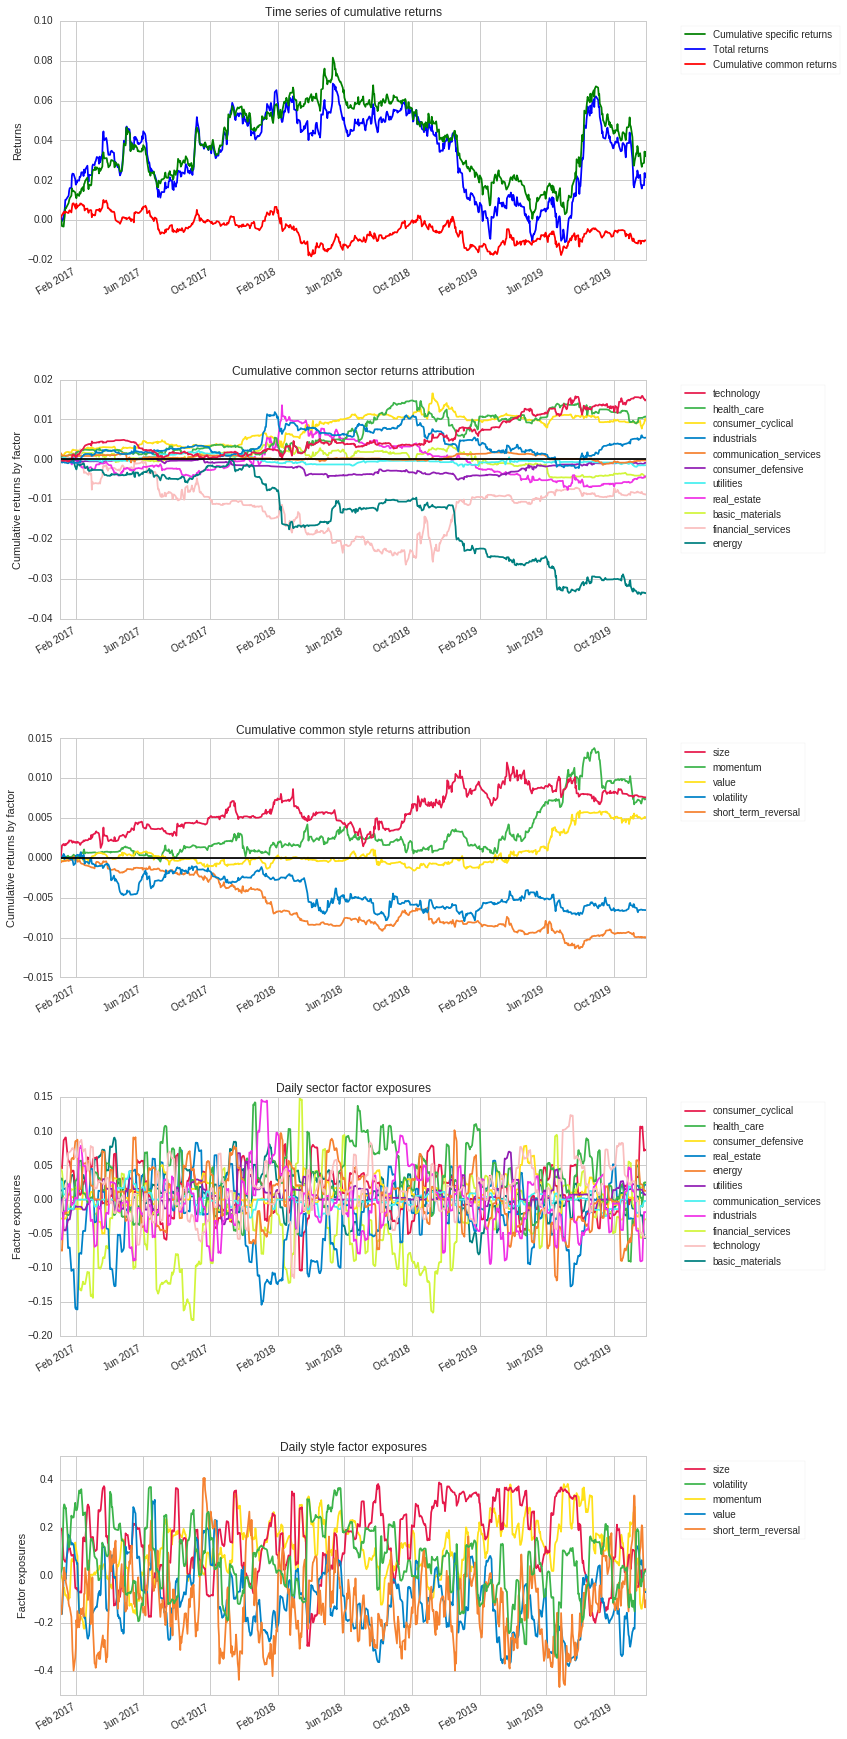

In [27]:
bt.create_perf_attrib_tear_sheet()

Some top positions used by the trading stratey over the entire backtest period.

Top 10 long positions of all time,max
RETA-49995,2.27%
TTD-50288,2.25%
PI-50138,2.10%
BOOM-1034,1.99%
MDCA-12800,1.94%
GTHX-50879,1.92%
ENVA-47979,1.88%
EHTH-32726,1.84%
HCC-50780,1.83%
DENN-18148,1.80%


Top 10 short positions of all time,max
TRUP-47331,-2.00%
GSHD-51962,-1.93%
ARCB-41,-1.86%
CMPR-27674,-1.85%
TGI-15905,-1.85%
SYNH-48027,-1.84%
GNW-26323,-1.81%
UFS-2329,-1.79%
SSD-11386,-1.79%
FORM-25182,-1.76%


Top 10 positions of all time,max
RETA-49995,2.27%
TTD-50288,2.25%
PI-50138,2.10%
TRUP-47331,2.00%
BOOM-1034,1.99%
MDCA-12800,1.94%
GSHD-51962,1.93%
GTHX-50879,1.92%
ENVA-47979,1.88%
ARCB-41,1.86%


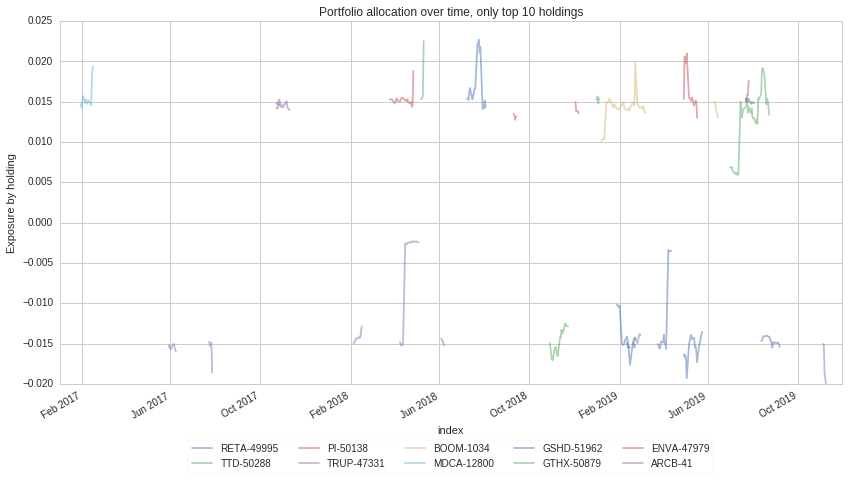

In [17]:
pos_percent = pf.pos.get_percent_alloc(bt_positions)
pf.plotting.show_and_plot_top_positions(bt_returns, pos_percent);